<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/02_baseline_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Baseline Model Evaluation

In [2]:
!pip install -q mlflow shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.5/677.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.6 MB/s eta 0:00:00
   ━━━━

In [3]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import lime
from lime.lime_tabular import LimeTabularExplainer
import os

### Import Recurrent Stroke Patient Data

In [36]:
processed_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FIT3199-FYP/input/00_recurrent_stroke_patient.csv')

In [6]:
# processed_df.drop(columns=['icd_code','icd_version','icd_title','stay_id','rhythm','pain','gender','dod','anchor_year_group'], inplace=True)

In [8]:
# # Convert the datetime column to datetime objects
# processed_df['charttime'] = pd.to_datetime(processed_df['charttime'])

# # Extract datetime components and add them as new columns
# processed_df['year'] = processed_df['charttime'].dt.year
# processed_df['month'] = processed_df['charttime'].dt.month
# processed_df['day'] = processed_df['charttime'].dt.day
# processed_df['hour'] = processed_df['charttime'].dt.hour
# processed_df['minute'] = processed_df['charttime'].dt.minute
# processed_df['second'] = processed_df['charttime'].dt.second

# # Convert the datetime column to datetime objects
# processed_df['dod'] = pd.to_datetime(processed_df['dod'])

# # Extract datetime components and add them as new columns
# processed_df['dod_year'] = processed_df['dod'].dt.year
# processed_df['dod_month'] = processed_df['dod'].dt.month
# processed_df['dod_day'] = processed_df['dod'].dt.day

# processed_df.drop(columns=['charttime','dod'], inplace=True)


In [40]:
processed_df = processed_df.fillna({
    'subject_id': 0,  # Integer columns -> 0
    'stay_id_x': 0.0,  # Float columns -> 0.0
    'temperature': 0.0,  # Float columns -> 0.0
    'heartrate': 0.0,  # Float columns -> 0.0
    'resprate': 0.0,  # Float columns -> 0.0
    'o2sat': 0.0,  # Float columns -> 0.0
    'sbp': 0.0,  # Float columns -> 0.0
    'dbp': 0.0,  # Float columns -> 0.0
    'rhythm': 0,  # Integer columns -> 0
    'pain': 0,  # Integer columns -> 0
    'year': 0,  # Float columns -> 0.0
    'month': 0,  # Integer columns -> 0
    'day': 0,  # Integer columns -> 0
    'hour': 0,  # Integer columns -> 0
    'minute': 0,  # Integer columns -> 0
    'second': 0,  # Integer columns -> 0
    'dod_year': 0.0,  # String columns -> '0.0'
    'dod_month': 0.0,  # String columns -> '0.0'
    'dod_day': 0.0  # String columns -> '0.0'
})

In [10]:
# Print the updated DataFrame
print(processed_df)

       subject_id            charttime  temperature  heartrate  resprate  \
0        10003299  2183-02-26 20:26:00         97.7       63.0      15.0   
1        10003299  2183-02-26 21:43:00          0.0       51.0      16.0   
2        10003299  2183-02-26 22:03:00          0.0       57.0      19.0   
3        10003299  2183-02-27 02:20:00          0.0       54.0      18.0   
4        10003299  2183-02-27 06:26:00         98.7       61.0      15.0   
...           ...                  ...          ...        ...       ...   
67962    19992885  2152-07-08 01:28:00         98.0       74.0      18.0   
67963    19992885  2152-07-08 01:28:00         98.0       74.0      18.0   
67964    19992885  2152-07-08 03:34:00         97.8       78.0      16.0   
67965    19992885  2152-07-08 03:34:00         97.8       78.0      16.0   
67966    19992885  2152-07-08 03:34:00         97.8       78.0      16.0   

       o2sat    sbp   dbp  seq_num  numeric_part  Stroke_Y/N  anchor_age  \
0       97.

In [ ]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [41]:
# Load dataset
df = processed_df.copy()  # Ensure `processed_df` is preloaded

# Convert `charttime` to datetime for correct time-based sorting
df["charttime"] = pd.to_datetime(df["charttime"])

# Sort data by patient, stay_id, and time
df = df.sort_values(by=["subject_id", "stay_id", "charttime"])

# Define features and target
features = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp"]
target = "Stroke_Y/N"

# Store cross-validation folds for each patient
train_test_data = {}

for subject_id, group in df.groupby("subject_id"):
    stay_ids = group["stay_id"].unique()

    if len(stay_ids) < 2:  # Need at least 2 admissions for train-test split
        print(f"Skipped {subject_id} with {len(stay_ids)} admissions.")
        continue

    for i in range(1, len(stay_ids)):  # Iterate through stays
        train_stays = stay_ids[:i]  # All previous stays for training
        test_stay = stay_ids[i]  # Next stay for testing

        train_data = group[group["stay_id"].isin(train_stays)]
        test_data = group[group["stay_id"] == test_stay]

        X_train, y_train = train_data[features].values, train_data[target].values
        X_test, y_test = test_data[features].values, test_data[target].values

        # Store train-test splits
        train_test_data[(subject_id, test_stay)] = {
            "X_train": X_train, "y_train": y_train,
            "X_test": X_test, "y_test": y_test,
        }

print("Train-test splits created based on hospital admissions.")

Train-test splits created based on hospital admissions.


In [43]:
X_train

array([[ 97.7,  63. ,  15. ,  97. , 146. ,  65. ],
       [  0. ,  51. ,  16. ,  97. , 131. ,  42. ],
       [  0. ,  57. ,  19. , 100. , 142. ,  54. ],
       [  0. ,  54. ,  18. ,  97. , 129. ,  56. ],
       [ 98.7,  61. ,  15. ,  98. , 123. ,  53. ],
       [ 98.6,  54. ,  18. ,  97. , 141. ,  72. ],
       [  0. ,  55. ,  20. ,  97. , 116. ,  67. ],
       [ 99.1,  55. ,  20. ,  99. , 145. ,  74. ]])

In [112]:
# !pip install mlflow pyngrok

# Define storage location in Google Drive
mlflow_storage = "/content/drive/MyDrive/mlflow_tracking"

# Start MLflow UI with persistent storage
import mlflow
from pyngrok import ngrok

# Start MLflow Tracking Server with the specified backend store
get_ipython().system_raw(f"mlflow server --backend-store-uri {mlflow_storage} --host 0.0.0.0 --port 5000 &")

# Expose the MLflow UI via ngrok
public_url = ngrok.connect(5000).public_url
print(f"MLflow Tracking UI is available at: {public_url}")

print(f"MLflow UI is available at: http://localhost:5000")



MLflow Tracking UI is available at: https://884f-35-233-207-161.ngrok-free.app
MLflow UI is available at: http://localhost:5000


In [109]:
import mlflow

mlflow.set_tracking_uri(public_url)

In [110]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load dataset
df = processed_df.copy()  # Ensure `processed_df` is preloaded

# Convert `charttime` to datetime for correct sorting
df["charttime"] = pd.to_datetime(df["charttime"])

# Sort by patient, stay_id, and time
df = df.sort_values(by=["subject_id", "stay_id", "charttime"])

# Define features and target
features = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp"]
target = "Stroke_Y/N"

# Split patients into training and test sets (80-20 split)
unique_patients = df["subject_id"].unique()
train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

# Separate data for training and testing
train_data = df[df["subject_id"].isin(train_patients)]
test_data = df[df["subject_id"].isin(test_patients)]

X_train, y_train = train_data[features].values, train_data[target].values
X_test, y_test = test_data[features].values, test_data[target].values

print(f"Training on {len(train_patients)} patients, Testing on {len(test_patients)} patients.")

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

# Start MLflow experiment
mlflow.set_experiment("Stroke Prediction Models")

# Train and evaluate each model
model_results = {}

for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        mlflow.sklearn.autolog()

        # Train model on all training patients
        model.fit(X_train, y_train)

        # Evaluate on test patients
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        # Store results
        model_results[model_name] = acc

        # Log accuracy in MLflow
        mlflow.log_metric("accuracy", acc)

# Print model performances
for model_name, acc in model_results.items():
    print(f"{model_name} - Accuracy: {acc:.4f}")


Training on 1081 patients, Testing on 271 patients.


2025/03/19 08:14:17 INFO mlflow.tracking.fluent: Experiment with name 'Stroke Prediction Models' does not exist. Creating a new experiment.


MlflowException: API request to endpoint /api/2.0/mlflow/runs/get failed with error code 404 != 200. Response body: '<!DOCTYPE html>
<html class="h-full" lang="en-US" dir="ltr">
  <head>
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Regular-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-RegularItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Medium-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Semibold-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-MediumItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/ibm-plex-mono/IBMPlexMono-Text.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/ibm-plex-mono/IBMPlexMono-TextItalic.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/ibm-plex-mono/IBMPlexMono-SemiBold.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/ibm-plex-mono/IBMPlexMono-SemiBoldItalic.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <meta charset="utf-8">
    <meta name="author" content="ngrok">
    <meta name="description" content="ngrok is the fastest way to put anything on the internet with a single command.">
    <meta name="robots" content="noindex, nofollow">
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <link id="style" rel="stylesheet" href="https://cdn.ngrok.com/static/css/error.css">
    <noscript>The endpoint 9c9d-35-233-207-161.ngrok-free.app is offline. (ERR_NGROK_3200)</noscript>
    <script id="script" src="https://cdn.ngrok.com/static/js/error.js" type="text/javascript"></script>
  </head>
  <body class="h-full" id="ngrok">
    <div id="root" data-payload="eyJjZG5CYXNlIjoiaHR0cHM6Ly9jZG4ubmdyb2suY29tLyIsImNvZGUiOiIzMjAwIiwibWVzc2FnZSI6IlRoZSBlbmRwb2ludCA5YzlkLTM1LTIzMy0yMDctMTYxLm5ncm9rLWZyZWUuYXBwIGlzIG9mZmxpbmUuIiwidGl0bGUiOiJOb3QgRm91bmQifQ=="></div>
  </body>
</html>
'

In [33]:
X_train

array([[  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. , 100. ,  24. ,  98. , 109. ,  90. ],
       [ 98.8,  75. ,  20. , 100. , 116. ,  56. ],
       [  0. ,  80. ,  18. , 100. , 107. ,  57. ],
       [  0. ,  76. ,  18. , 100. , 132. ,  43. ],
       [ 97.8,  86. ,  16. , 100. , 128. ,  55. ],
       [  0. ,  99. ,  16. , 100. , 105. ,  52. ],
       [ 98.1,  96. ,  24. ,  96. , 104. ,  60. ],
       [  0. ,  97. ,  22. ,  97. , 103. ,  66. ],
       [  0. ,  97. ,  18. , 100. , 111. ,  64. ]])

In [34]:
X_test

array([[  0. ,  99. ,  18. ,  97. , 111. ,  60. ],
       [  0. ,  99. ,  18. ,  99. , 111. ,  62. ],
       [ 98.3,  97. ,  18. ,  99. , 112. ,  64. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ]])

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load dataset
# Load dataset
df = processed_df.copy()  # Replace with actual file path

# Convert `charttime` to datetime for correct time-based sorting
df["charttime"] = pd.to_datetime(df["charttime"])
# Sort data by patient and time
df = df.sort_values(by=["subject_id", "charttime"])

# Define features and target
features = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp"]
target = "Stroke_Y/N"

# Store cross-validation folds for each patient
folds_by_patient = {}

# Step 1: Split first (Store train-test indices for each patient)
for subject_id, group in df.groupby("subject_id"):
    X = group[features].values
    y = group[target].values

    if len(group) < 3:  # Skip patients with too few visits
        print(f"Skipped {subject_id} with {len(group)} visits.")
        continue

    tscv = TimeSeriesSplit(n_splits=2)
    folds_by_patient[subject_id] = list(tscv.split(X))  # Store the splits

# Step 2: Train & Evaluate (Use stored folds)
cv_results = []

for subject_id, group in df.groupby("subject_id"):
    if subject_id not in folds_by_patient:
        continue

    X = group[features].values
    y = group[target].values

    fold_scores = []

    for train_idx, test_idx in folds_by_patient[subject_id]:  # Use stored indices
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train model
        model = DecisionTreeClassifier(random_state=42)
        model.fit(X_train, y_train)

        # Evaluate
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        fold_scores.append(acc)

    # Store average accuracy for this patient
    cv_results.append(np.mean(fold_scores))

# Print overall performance
print(f"Average accuracy across patients: {np.mean(cv_results):.4f}")


Skipped 15746236 with 2 visits.
Average accuracy across patients: 0.7139


In [12]:
print(len(X_train))

25


In [13]:
X_train

array([[  0. ,  71. ,  16. ,  97. ,  96. ,  51. ],
       [  0. ,  71. ,  16. ,  97. ,  96. ,  51. ],
       [  0. ,  71. ,  16. ,  97. ,  96. ,  51. ],
       [  0. ,  72. ,   0. ,  98. ,  88. ,  50. ],
       [  0. ,  72. ,   0. ,  98. ,  88. ,  50. ],
       [  0. ,  72. ,   0. ,  98. ,  88. ,  50. ],
       [ 97.8,  73. ,  15. ,  98. , 108. ,  56. ],
       [ 97.8,  73. ,  15. ,  98. , 108. ,  56. ],
       [ 97.8,  73. ,  15. ,  98. , 108. ,  56. ],
       [ 97.7,  69. ,  13. ,  95. ,  91. ,  52. ],
       [ 97.7,  69. ,  13. ,  95. ,  91. ,  52. ],
       [ 97.7,  69. ,  13. ,  95. ,  91. ,  52. ],
       [ 97.4,  79. ,  14. ,  98. , 114. ,  61. ],
       [ 97.4,  79. ,  14. ,  98. , 114. ,  61. ],
       [ 97.4,  79. ,  14. ,  98. , 114. ,  61. ],
       [  0. ,  77. ,   0. ,  97. , 124. ,  63. ],
       [  0. ,  77. ,   0. ,  97. , 124. ,  63. ],
       [  0. ,  77. ,   0. ,  97. , 124. ,  63. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   

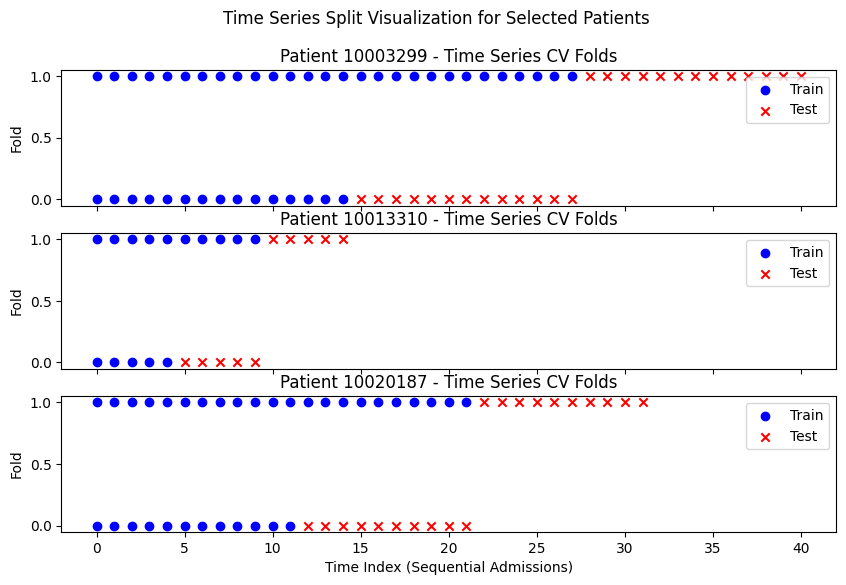

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

df = processed_df.copy()  # Replace with actual file path

# Convert `charttime` to datetime for correct time-based sorting
df["charttime"] = pd.to_datetime(df["charttime"])
# Sort data by patient and time
df = df.sort_values(by=["subject_id", "charttime"])

# Define features and target
features = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp"]
target = "Stroke_Y/N"

# Select a few example patients for visualization
example_patients = df["subject_id"].unique()[:3]  # Select first 3 patients

# Plot each patient’s fold splits
fig, axes = plt.subplots(len(example_patients), 1, figsize=(10, 6), sharex=True)

if len(example_patients) == 1:
    axes = [axes]  # Ensure axes is always iterable

for ax, subject_id in zip(axes, example_patients):
    group = df[df["subject_id"] == subject_id]
    X = group[features].values
    y = group[target].values

    # tscv = TimeSeriesSplit(n_splits=3)

    ax.set_title(f"Patient {subject_id} - Time Series CV Folds")

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        ax.scatter(train_idx, [fold] * len(train_idx), color="blue", marker="o", label="Train" if fold == 0 else "")
        ax.scatter(test_idx, [fold] * len(test_idx), color="red", marker="x", label="Test" if fold == 0 else "")

    ax.set_ylabel("Fold")
    ax.legend()

plt.xlabel("Time Index (Sequential Admissions)")
plt.suptitle("Time Series Split Visualization for Selected Patients")
plt.show()


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
df = processed_df.copy()  # Replace with actual file path

# Convert `charttime` to datetime for correct time-based sorting
df["charttime"] = pd.to_datetime(df["charttime"])

# Step 1: Sort by patient (`subject_id`) and time (`charttime`)
df = df.sort_values(by=["subject_id", "charttime"])

# Step 2: Get unique patient IDs
unique_patients = df["subject_id"].unique()

# Step 3: Split patients into train (60%), validation (20%), and test (20%)
train_patients, temp_patients = train_test_split(unique_patients, test_size=0.4, random_state=42)
val_patients, test_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

# Step 4: Assign train, validation, and test sets based on patient split
train_df = df[df["subject_id"].isin(train_patients)]
val_df = df[df["subject_id"].isin(val_patients)]
test_df = df[df["subject_id"].isin(test_patients)]

# Step 5: Ensure time-based splitting within each patient
def split_time_based(group):
    """Splits each patient's records into time-based train, val, and test sets."""
    total_visits = len(group)
    train_cutoff = int(total_visits * 0.6)
    val_cutoff = int(total_visits * 0.8)

    train = group.iloc[:train_cutoff]
    val = group.iloc[train_cutoff:val_cutoff]
    test = group.iloc[val_cutoff:]

    return train, val, test

# Apply time-based split to each patient group
train_df_list, val_df_list, test_df_list = [], [], []

for patient_id, group in df.groupby("subject_id"):
    train, val, test = split_time_based(group)
    train_df_list.append(train)
    val_df_list.append(val)
    test_df_list.append(test)

# Concatenate results
train_df = pd.concat(train_df_list)
val_df = pd.concat(val_df_list)
test_df = pd.concat(test_df_list)

# Step 6: Verify the split
print(f"Train set: {train_df.shape}, Validation set: {val_df.shape}, Test set: {test_df.shape}")
print(f"Train time range: {train_df['charttime'].min()} - {train_df['charttime'].max()}")
print(f"Validation time range: {val_df['charttime'].min()} - {val_df['charttime'].max()}")
print(f"Test time range: {test_df['charttime'].min()} - {test_df['charttime'].max()}")

# Step 7: Prepare ML datasets
X_train, y_train = train_df.drop(columns=["Stroke_Y/N"]), train_df["Stroke_Y/N"]
X_val, y_val = val_df.drop(columns=["Stroke_Y/N"]), val_df["Stroke_Y/N"]
X_test, y_test = test_df.drop(columns=["Stroke_Y/N"]), test_df["Stroke_Y/N"]



Train set: (40254, 13), Validation set: (13589, 13), Test set: (14124, 13)
Train time range: 2110-01-21 03:57:00 - 2212-01-19 16:36:00
Validation time range: 2110-07-01 03:41:00 - 2212-04-06 01:45:00
Test time range: 2110-07-01 04:51:00 - 2212-04-06 12:20:00


In [16]:
X_train

,subject_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,seq_num,numeric_part,anchor_age,anchor_year
22,10003299,2178-12-10 18:19:00,0.0,58.0,18.0,97.0,149.0,71.0,1,5789,65,2173
23,10003299,2178-12-10 19:28:00,98.4,68.0,17.0,97.0,121.0,65.0,1,5789,65,2173
24,10003299,2178-12-10 21:11:00,98.5,60.0,18.0,98.0,149.0,63.0,1,5789,65,2173
35,10003299,2179-06-30 09:41:00,0.0,59.0,15.0,97.0,141.0,65.0,1,43491,65,2173
36,10003299,2179-06-30 09:41:00,0.0,59.0,15.0,97.0,141.0,65.0,2,72989,65,2173
...,...,...,...,...,...,...,...,...,...,...,...,...
67947,19992885,2152-06-20 07:21:00,0.0,77.0,0.0,97.0,124.0,63.0,3,4589,50,2152
67948,19992885,2152-06-20 08:20:00,0.0,0.0,0.0,0.0,0.0,0.0,1,99811,50,2152
67949,19992885,2152-06-20 08:20:00,0.0,0.0,0.0,0.0,0.0,0.0,2,8799,50,2152
67950,19992885,2152-06-20 08:20:00,0.0,0.0,0.0,0.0,0.0,0.0,3,4589,50,2152


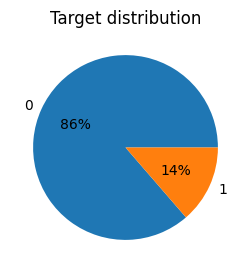

In [17]:
targets = processed_df['Stroke_Y/N']

temp = targets.value_counts()
temp

plt.figure(figsize=(6, 3))
plt.pie(temp, labels=temp.index, autopct="%.0f%%")
plt.title('Target distribution')
plt.show()

### Time Series Splitting


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# Load dataset
df = processed_df.copy()  # Ensure `processed_df` is preloaded

# Convert `charttime` to datetime for correct time-based sorting
df["charttime"] = pd.to_datetime(df["charttime"])

# Sort data by patient and time
df = df.sort_values(by=["subject_id", "charttime"])

# Define features and target
features = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp"]
target = "Stroke_Y/N"

# Store cross-validation folds for each patient
folds_by_patient = {}

# Generate train-test splits per patient
train_test_data = {}  # Store actual train-test sets

for subject_id, group in df.groupby("subject_id"):
    X = group[features].values
    y = group[target].values

    if len(group) < 3:  # Skip patients with too few visits
        print(f"Skipped {subject_id} with {len(group)} visits.")
        continue

    tscv = TimeSeriesSplit(n_splits=2)
    folds = list(tscv.split(X))

    # Store fold indices
    folds_by_patient[subject_id] = folds

    # Store actual train-test sets for future use
    train_idx, test_idx = folds[-1]  # Last fold for testing
    train_test_data[subject_id] = {
        "X_train": X[train_idx],
        "X_test": X[test_idx],
        "y_train": y[train_idx],
        "y_test": y[test_idx],
    }

print("Time series splits stored successfully.")


Skipped 15746236 with 2 visits.
Time series splits stored successfully.


###  Model Training & Evaluation

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define models to test
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(),
}

# Store results
model_results = {model_name: [] for model_name in models.keys()}

# Iterate through patients and evaluate models
for subject_id, data in train_test_data.items():
    X_train, X_test = data["X_train"], data["X_test"]
    y_train, y_test = data["y_train"], data["y_test"]

    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Evaluate
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        # Store results
        model_results[model_name].append(acc)

# Print performance results
for model_name, scores in model_results.items():
    print(f"{model_name} - Average Accuracy: {np.mean(scores):.4f}")


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

In [29]:
X_train

,subject_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,seq_num,numeric_part,anchor_age,anchor_year
0,10003299,2183-02-26 20:26:00,97.7,63.0,15.0,97.0,146.0,65.0,1,918,65,2173
1,10003299,2183-02-26 21:43:00,0.0,51.0,16.0,97.0,131.0,42.0,1,918,65,2173
2,10003299,2183-02-26 22:03:00,0.0,57.0,19.0,100.0,142.0,54.0,1,918,65,2173
3,10003299,2183-02-27 02:20:00,0.0,54.0,18.0,97.0,129.0,56.0,1,918,65,2173
5,10003299,2183-02-27 10:11:00,98.6,54.0,18.0,97.0,141.0,72.0,1,918,65,2173
...,...,...,...,...,...,...,...,...,...,...,...,...
67961,19992885,2152-07-08 01:28:00,98.0,74.0,18.0,99.0,118.0,55.0,1,9972,50,2152
67962,19992885,2152-07-08 01:28:00,98.0,74.0,18.0,99.0,118.0,55.0,2,4423,50,2152
67963,19992885,2152-07-08 01:28:00,98.0,74.0,18.0,99.0,118.0,55.0,3,8788,50,2152
67965,19992885,2152-07-08 03:34:00,97.8,78.0,16.0,96.0,125.0,74.0,2,4423,50,2152


In [19]:
y

,Stroke_Y/N
0,0
1,0
2,0
3,0
4,0
...,...
67962,0
67963,0
67964,0
67965,0


In [20]:
# # Save X_test and y_test
# X_test.to_csv("X_test.csv", index=False)
# y_test.to_csv("y_test.csv", index=False)

# # Save X_val and y_val
# X_val.to_csv("X_val.csv", index=False)
# y_val.to_csv("y_val.csv", index=False)

# print("Test and validation sets saved successfully.")


## Baseline Model Training

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import numpy as np

# Define models to evaluate
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naïve Bayes": GaussianNB(),
    # "SVC": SVC(kernel='rbf', probability=True, random_state=42),

}

# Define number of folds
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Iterate over models
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")

    f1_scores, precision_scores, recall_scores, accuracy_scores = [], [], [], []

    # Perform K-Fold Cross Validation
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train model
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)

        # Compute metrics
        f1_scores.append(f1_score(y_val, y_val_pred, average='weighted'))
        precision_scores.append(precision_score(y_val, y_val_pred, average='weighted'))
        recall_scores.append(recall_score(y_val, y_val_pred, average='weighted'))
        accuracy_scores.append(accuracy_score(y_val, y_val_pred))

    # Print average performance for this model
    print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
    print(f"Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
    print(f"Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")



Evaluating Decision Tree...


ValueError: could not convert string to float: '2183-02-26 20:26:00'

### SHAP and LIME Analysis

#### SHAP

In [ ]:
#  create a SHAP explainer and calculate SHAP values for the test set
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_test)


In [ ]:
import shap
import matplotlib.pyplot as plt

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test)


##### Summary Plot Insights

Notes:

**Observations**


**Key Takeaway**


In [ ]:
X_test

##### Dependence Plot Insights

Notes:


**Observations**


**Key Takeaway**



#### LIME

In [ ]:
# lime_explanation = explainer_lime.explain_instance(X_test.iloc[0].values, model.predict_proba, num_features=10)
# lime_explanation.as_pyplot_figure()
# plt.show()

##### Insights
**Observations**



**Key Takeaway**


### Model Tracking With MLFlow

In [22]:
!pip install -q mlflow pyngrok

In [79]:
!lsof -i:8081

COMMAND   PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
python3 17370 root    3u  IPv4 518540      0t0  TCP *:8081 (LISTEN)


In [87]:
import mlflow
import os
from getpass import getpass

os.environ['MLFLOW_TRACKING_USERNAME'] = input('Enter your DAGsHub username: ')
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token: ')
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = input('Enter your DAGsHub project name: ')

mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

Enter your DAGsHub username: Zfeng0207
Enter your DAGsHub access token: ··········
Enter your DAGsHub project name: my-first-repo


KeyboardInterrupt: 

In [86]:
# See your experiments table inside Colab!
import IPython
display(IPython.display.IFrame("https://dagshub.com/"+ os.environ['MLFLOW_TRACKING_USERNAME']
                        + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + "/experiments/#/",'100%',600))

In [55]:
! pip install flask

In [69]:
!flask run --host=0.0.0.0 --port=8081

Usage: flask run [OPTIONS]
Try 'flask run --help' for help.

Error: Could not locate a Flask application. Use the 'flask --app' option, 'FLASK_APP' environment variable, or a 'wsgi.py' or 'app.py' file in the current directory.


In [74]:
import mlflow

# with mlflow.start_run(run_name="MLflow on Colab"):
#   mlflow.log_metric("m1", 2.0)
#   mlflow.log_param("p1", "mlflow-colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2uWYxl81mvhrlbPAlGT3XltnT2R_7cg1jDs2PbS7iYv6Vh5jc"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="8081", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://7017-35-233-207-161.ngrok-free.app


In [78]:
# !pip install pyngrok
from pyngrok import ngrok

# Start an HTTP server on port 9090
!python -m http.server 8081 &

# Expose it with ngrok
public_url = ngrok.connect(8081)
print(f"Public URL: {public_url}")


Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/lib/python3.11/http/server.py", line 1313, in <module>
    test(
  File "/usr/lib/python3.11/http/server.py", line 1260, in test
    with ServerClass(addr, HandlerClass) as httpd:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socketserver.py", line 456, in __init__
    self.server_bind()
  File "/usr/lib/python3.11/http/server.py", line 1307, in server_bind
    return super().server_bind()
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/http/server.py", line 136, in server_bind
    socketserver.TCPServer.server_bind(self)
  File "/usr/lib/python3.11/socketserver.py", line 472, in server_bind
    self.socket.bind(self.server_address)
OSError: [Errno 98] Address already in use
Public URL: NgrokTunnel: "https://739c-35-233-207-161.ngrok-free.app" -> "http://localhost:8081"


In [91]:
from pyngrok import ngrok

ngrok.kill()  # Stop any existing tunnels

# Set your authtoken
ngrok.set_auth_token("2uWYxl81mvhrlbPAlGT3XltnT2R_7cg1jDs2PbS7iYv6Vh5jc")  # Replace with your actual authtoken

# Now you can use ngrok as usual
public_url = ngrok.connect(8081).public_url
print(f"MLflow Tracking UI: {public_url}")


MLflow Tracking UI: https://293e-35-233-207-161.ngrok-free.app


In [68]:
!fuser -k 8081/tcp

In [84]:
!curl -v http://localhost:8081/


*   Trying 127.0.0.1:8081...
* Connected to localhost (127.0.0.1) port 8081 (#0)
> GET / HTTP/1.1
> Host: localhost:8081
> User-Agent: curl/7.81.0
> Accept: */*
> 
* Empty reply from server
* Closing connection 0
curl: (52) Empty reply from server


In [93]:
from pyngrok import ngrok

# Set your authtoken
ngrok.set_auth_token("2uWYxl81mvhrlbPAlGT3XltnT2R_7cg1jDs2PbS7iYv6Vh5jc")  # Replace with your actual authtoken

# Now you can use ngrok as usual
public_url = ngrok.connect(8080).public_url
print(f"MLflow Tracking UI: {public_url}")

MLflow Tracking UI: https://e7c2-35-233-207-161.ngrok-free.app


In [ ]:
from pyngrok import ngrok

# Expose port 5000 to the internet
public_url = ngrok.connect(5000)
print(f"MLflow Tracking Server URL: {public_url}")


In [ ]:
train_data = X_train.copy()
train_data['category'] = y_train

val_data = X_val.copy()
val_data['category'] = y_val

test_data = X_test.copy()
test_data['category'] = y_test

In [ ]:
train_df = mlflow.data.from_pandas(train_data, source=preprocessed_data_path)
val_df = mlflow.data.from_pandas(val_data, source=preprocessed_data_path)
test_df = mlflow.data.from_pandas(test_data, source=preprocessed_data_path)

In [ ]:
# logging with MLflow

data_source_path = "preprocessed_data.csv"

with mlflow.start_run():

    # log the dataset used
    mlflow.log_input(train_df, context='training')
    mlflow.log_input(val_df, context='validation')
    mlflow.log_input(test_df, context='testing')

    #log artifacts, no parameters to log yet
    mlflow.log_artifact(data_source_path, artifact_path="model_data")


    # log tags
    mlflow.set_tags({
        "model_type": "RandomForest",
        "framework": "sklearn",
        "experiment_name": "Model_Experiment",
        "random_state": "42"
    })

    # log parameter source code
    mlflow.log_param("source_code", "train_model.py")  # Replace with your actual script/file

    # log model
    mlflow.sklearn.log_model(model, "model")

    # log metrics
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("test_f1", test_f1)

    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("test_precision", test_precision)

    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("test_recall", test_recall)

    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)